# Attention mechanism for sentiment analysis

In this lab we use part of the 'Amazon_Unlocked_Mobile.csv' dataset published by Kaggle. The dataset contain the following information:
* Product Name
* Brand Name
* Price
* Rating
* Reviews
* Review Votes

We are mainly interested by the 'Reviews' (X) and by the 'Rating' (y)


The goal is to try to predict the 'Rating' after reading the 'Reviews'. I've prepared for you TRAIN and TEST set.
The work to be done is as follows:

1. Feature extraction and baseline
    * read the dataset and understand it
    * put it in a format so that you can use `CountVectorizer` or`Tf-IDF` to extract the desired features
    * perform on the desired dates and preprocessing
    * use one of the classifiers you know to predict the polarity of different sentences
1. My first neural network
    * reuse the features already extracted 
    * proposed a neural network built with Keras
1. Hyper-parameter fitting
    * for the base line: adjust min_df, max_df, ngram, max_features + model's hyper-parameter
    * for the neural network: adjust batch size, number of layers and number of neuron by layers, use earlystop
1. <span style="color:red">Word embedding
    * stage 1 build a network that uses Keras' embedding which is not language sensitive.
    * stage 2 build a network that simultaneously uses Keras' embedding and the features extracted in the first weeks.
    * stage 3 try to use an existing embedding (https://github.com/facebookresearch/MUSE)
    </span>

**WARNING:** the dataset is voluminous, I can only encourage you to work first on a small part of it and only at the end, when the code is well debugged and that it is necessary to build the "final model", to use the whole dataset.

In [1]:
"""
(Practical tip) Table of contents can be compiled directly in jupyter notebooks using the following code:
I set an exception: if the package is in your installation you can import it otherwise you download it 
then import it.
"""
try:
    from jyquickhelper import add_notebook_menu 
except:
    !pip install jyquickhelper
    from jyquickhelper import add_notebook_menu
    
"""
Output Table of contents to navigate easily in the notebook. 
For interested readers, the package also includes Ipython magic commands to go back to this cell
wherever you are in the notebook to look for cells faster
"""
add_notebook_menu()

## Imports

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import OneHotEncoder

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, TextVectorization, Embedding, Dense, Dropout, Activation
from tensorflow.keras.layers import TimeDistributed, LSTM, Bidirectional
from tensorflow.keras.layers import Flatten, RepeatVector, Dot, Permute, AveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [5]:
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

## Read the dataset

Could you find below a proposal. You can complete them.

In [6]:
TRAIN = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/train.csv.gz").fillna(value="")
VAL = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/val.csv.gz").fillna(value="")
TEST = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/test.csv.gz").fillna(value="")

TRAIN.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,Samsung Galaxy Note 4 N910C Unlocked Cellphone...,Samsung,449.99,4,I love it!!! I absolutely love it!! 👌👍,0
1,BLU Energy X Plus Smartphone - With 4000 mAh S...,BLU,139,5,I love the BLU phones! This is my second one t...,4
2,Apple iPhone 6 128GB Silver AT&T,Apple,599.95,5,Great phone,1
3,BLU Advance 4.0L Unlocked Smartphone -US GSM -...,BLU,51.99,4,Very happy with the performance. The apps work...,2
4,Huawei P8 Lite US Version- 5 Unlocked Android ...,Huawei,198.99,5,Easy to use great price,0


In [7]:
''' Construct X_train and y_train '''
X_train = np.array(TRAIN['Reviews']).reshape(-1,1)

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train = ohe.fit_transform(np.array(TRAIN['Rating']).reshape(-1,1))

X_train.shape, y_train.shape

((5000, 1), (5000, 5))

In [8]:
''' Do the same for val '''
X_val = np.array(VAL['Reviews']).reshape(-1,1)
y_val = ohe.transform(np.array(VAL['Rating']).reshape(-1,1))

''' Do the same for test '''
X_test = np.array(TEST['Reviews']).reshape(-1,1)
y_test = ohe.transform(np.array(TEST['Rating']).reshape(-1,1))

## Build an a neural network with vectorized embedding and RNN cells.

The task is to predict the sentiment according to the content of the review. We can treat this kind of task by a Many-to-one model.

![LSTM for sentiment analysis](https://www.programmerall.com/images/679/8c/8c66e6ee3b9418358a791b363572bedf.jpeg)

Implement such a network with :
- a first layer of type LSTM
- a second layer of type LSTM, each cell of this layer will be fed by the corresponding output of the first layer (see figure above).



## Answers: 
<font color='red'>
1. Before modifying the code, take the time to understand it well. We use here the global attentions mechanism only from an encoder since the network for sentiment analysis has no decoder part, only a classifier 1

In [9]:
# Constants
nb_classes = y_train.shape[1]
vocab_size = 3000    # Maximum vocab size to have more accurate prediction 
embedding_size = 300 # Embedding size
recurrent_size = 64 # Recurrent size
hidden_size = recurrent_size//4    # Hidden layer
dropout_rate = 0.2   # Dropout rate for regularization
max_len = 100         # Sequence length to pad the outputs to -- adjust with the distribution of the reviews length
learning_rate=0.000001 #modifying the learning rate to learn more from our data 

In [10]:
# Create the vectorized layer.
vectorize_layer = TextVectorization(max_tokens=vocab_size,
                                    standardize="lower_and_strip_punctuation",
                                    # it is possible to build your own function
                                    # to transform emoji into text
                                    # to transform foreign reviews in english one
                                    # etc.
                                    output_mode='int',
                                    output_sequence_length=max_len)

In [11]:
# Fit vectorized layer on train
vectorize_layer.adapt(X_train)

<font color='red'>
$To\ do\ student$

1. Understand the code
1. Play with LSTM model for sentiment analysis
    * Replace LSTM by BI-LSTM
    * Use stacked LSTM or BI-LSTM
    * Use all hidden state and average it
</font>

<font color='green'>
$If\ you\ want\ to\ go\ further$

If you are interested in the subject, current networks for sentiment prediction combine a part with recurrent networks (LTSM) to capture long dependencies and a part with convolution (CNN) to capture short dependencies. [This resarch paper](https://arxiv.org/pdf/1904.04206.pdf) or [this one](https://hal.archives-ouvertes.fr/hal-03052803/document) describe some accurate networks for sentiment analysis.

Here, another paper that gives you some indications to go further: [Attention, CNN and what not for Text Classification](https://mlwhiz.com/blog/2019/03/09/deeplearning_architectures_text_classification/)

You will see next week the CNN with Diane. So there is no need to use them today.
</font>

<font color='red'>
Improve the f1 score for the Attentional LSTM model using BI-LSTM approach, better hyper-parameters and a better preprocessing (the same as in the previous step)

## Attention with LSTM network



In [28]:
# ------------------------------------------------------
# MODEL BUILDING
# ------------------------------------------------------
def build_model():
    # Input: a review
    input_ = Input(shape=(1, ), name="input", dtype=tf.string)

    # Transform the review in a list of tokenID
    vect = vectorize_layer(input_)

    # Keras embedding
    embedding = Embedding(vocab_size,
                          embedding_size, 
                          weights=None,  # Without pre-learning
                          trainable=True,# Trainable
                          name='embedding'
                         )(vect)
    
    # You can try also a Bidirectionnel cell
    rnn = Bidirectional(LSTM(recurrent_size, return_sequences=True, 
               return_state=False,
               dropout=dropout_rate, recurrent_dropout=dropout_rate))(embedding),#adding 2 BILSTM layers to the model
    rnn = Bidirectional(LSTM(recurrent_size, return_sequences=True, 
               return_state=False,
               dropout=dropout_rate, recurrent_dropout=dropout_rate))(rnn)
    # In the case of LSTM, there are two internal states
    #      the hidden state, usually denoted by h,
    #      the cell state usually denoted by c
    # The tuple (c, h) is the internal state of a LSTM
    # return_sequences=True gives you the hidden state (h) of the LSTM for every timestep
    # used in combination with return_state=True, you will only get the tuple (c, h) for the final timestep

    # Attention layer
    attention = Dense(1, activation='tanh')(rnn)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
  

    # Pour pouvoir faire la multiplication (scalair/vecteur KERAS)
    attention = RepeatVector(recurrent_size)(attention) # NORMAL RNN
    attention = Permute([2, 1])(attention)
  
    # Application de l'attention sur la sortie du RNN
    sent_representation = Dot(axes=1, normalize=False)([rnn, attention])
    
    # Flatten pour entrer dans le Dense
    flatten = Flatten()(sent_representation)
    
    # Dense pour la classification avec 1 couche cachee
    hidden_dense = Dense(hidden_size, activation="relu")(flatten)
    hidden_dense = Dropout(dropout_rate)(hidden_dense)

    # Classification et ouput
    output_ = Dense(nb_classes, activation='softmax')(hidden_dense)
    
    # Build  model
    model = Model(inputs=input_, outputs=output_)
    
    return model

model = build_model()

In [29]:
# Plot model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='LSTM_with_attention.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [30]:
# Compile the model
f1 = F1Score(num_classes=nb_classes, average="macro", threshold=0.5)
op = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=op, loss='categorical_crossentropy', metrics=[f1])

In [31]:
# fit model using ealy stopping
es = EarlyStopping(monitor='val_f1_score', mode='max', patience=10, restore_best_weights=True, verbose=2)
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val), 
                    epochs=4000, callbacks=[es], verbose=1)

Epoch 1/4000
157/157 [==============================] - 120s 672ms/step - loss: 1.5813 - f1_score: 0.0000e+00 - val_loss: 1.5679 - val_f1_score: 0.0000e+00
Epoch 2/4000
157/157 [==============================] - 102s 651ms/step - loss: 1.5591 - f1_score: 0.0000e+00 - val_loss: 1.5429 - val_f1_score: 0.0000e+00
Epoch 3/4000
157/157 [==============================] - 106s 672ms/step - loss: 1.5337 - f1_score: 0.0000e+00 - val_loss: 1.5140 - val_f1_score: 0.0000e+00
Epoch 4/4000
157/157 [==============================] - 103s 656ms/step - loss: 1.5075 - f1_score: 0.0000e+00 - val_loss: 1.4817 - val_f1_score: 0.0000e+00
Epoch 5/4000
157/157 [==============================] - 105s 671ms/step - loss: 1.4759 - f1_score: 0.0000e+00 - val_loss: 1.4451 - val_f1_score: 0.0000e+00
Epoch 6/4000
157/157 [==============================] - 104s 660ms/step - loss: 1.4423 - f1_score: 0.0000e+00 - val_loss: 1.4057 - val_f1_score: 0.0000e+00
Epoch 7/4000
157/157 [==============================] - 106s 672

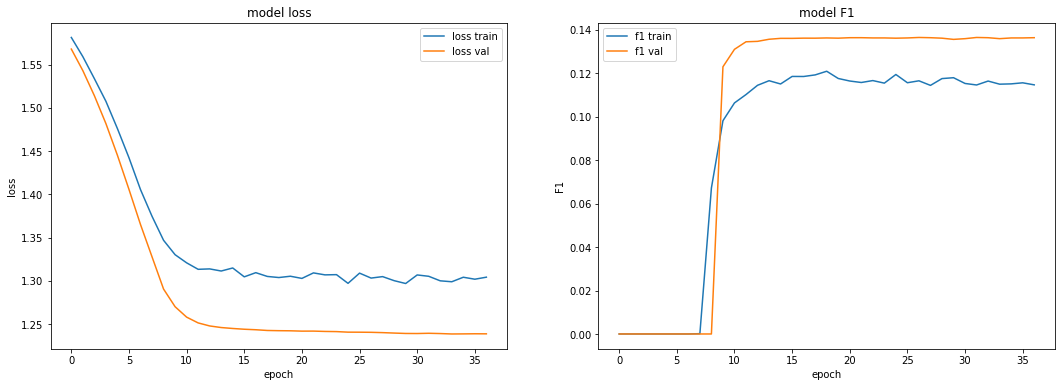

In [32]:
# plot history
babysit(history)

## Conclusion: 
<font color=" green">
The model loss has been descreasing smoothly after adding BiLSTM instead of LSTM layer. <br>
    The results displayed with 2 BiLSTM layers. These findings can be improved more better by modifying 
    learning rate, max_len, vocab_size. As a results, the runing time of this model is slow and it requires more 
    memory space (so costly) 


In [33]:
# Evaluate the model
f1.update_state(y_test, model.predict(X_test))
print('F1: %f' % (f1.result().numpy()))

F1: 0.138487


## Use Attentionnal model

In [34]:
# ------------------------------------------------------
# GET ATTENTION MODEL
# ------------------------------------------------------
def get_attention_model(model):
    attention_layer_indice = 0
    for layer in model.layers:
        print(type(layer))
        if type(layer) is Activation:
            break
        else:
            attention_layer_indice += 1

    # Create an attention model
    return Model(inputs=model.layers[0].input, outputs=model.layers[attention_layer_indice].output)

In [35]:
# PLOT ATTENTION MODEL from classifier model with ATTENTION
attention_model = get_attention_model(model)
plot_model(attention_model, show_shapes=True, show_layer_names=True, to_file='model_get_attention.png')

<class 'keras.engine.input_layer.InputLayer'>
<class 'keras.layers.preprocessing.text_vectorization.TextVectorization'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.wrappers.Bidirectional'>
<class 'keras.layers.wrappers.Bidirectional'>
<class 'keras.layers.core.Dense'>
<class 'keras.layers.core.Flatten'>
<class 'keras.layers.core.Activation'>
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [36]:
# ------------------------------------------------------
# GET ATTENTION
# ------------------------------------------------------
attentions = attention_model.predict(X_val[0])
attentions

array([[0.01121821, 0.01124247, 0.01123727, 0.01118135, 0.01111372,
        0.01103709, 0.01095429, 0.01086806, 0.0107808 , 0.01069454,
        0.01061088, 0.01053102, 0.01045582, 0.0103858 , 0.01032124,
        0.01026223, 0.01020869, 0.01016042, 0.01011717, 0.0100786 ,
        0.01004438, 0.01001413, 0.0099875 , 0.00996413, 0.00994368,
        0.00992584, 0.00991032, 0.00989685, 0.00988517, 0.00987508,
        0.00986637, 0.00985886, 0.00985241, 0.00984686, 0.00984209,
        0.00983801, 0.00983451, 0.00983151, 0.00982895, 0.00982675,
        0.00982487, 0.00982326, 0.00982187, 0.00982068, 0.00981965,
        0.00981876, 0.00981798, 0.00981729, 0.00981668, 0.00981612,
        0.00981561, 0.00981514, 0.00981469, 0.00981425, 0.00981381,
        0.00981337, 0.00981292, 0.00981245, 0.00981195, 0.00981142,
        0.00981085, 0.00981023, 0.00980957, 0.00980885, 0.00980808,
        0.00980726, 0.00980638, 0.00980544, 0.00980446, 0.00980343,
        0.00980237, 0.0098013 , 0.00980022, 0.00

In [37]:
# ------------------------------------------------------
# GET ATTENTION for each WORD
# ------------------------------------------------------
from sklearn import preprocessing

def get_attention(X, y, prediction, attention, N=5):
    # normalize attention (without the padding part)
    normalized_attention = preprocessing.QuantileTransformer().fit_transform(attention)
  
    results = []
    for i, (X_, y_, p_, a_) in enumerate(zip(X, y, prediction, normalized_attention)):
        if i>N:
            break
        # build result
        result_entry = {}
        result_entry["prediction"] = (np.argmax(y_), np.argmax(p_))
        result_entry["original"] = np.asscalar(X_)
        result_entry["sentence"] = []
        for j, word in enumerate(vectorize_layer(X_).numpy().flatten().tolist()):
            word_obj = {}
            if word==0:
                break
            word_obj[vectorize_layer.get_vocabulary()[word]] = a_[j].item()
            result_entry["sentence"].append(word_obj)
            
        results += [result_entry]
    return results

sentences_with_attention = get_attention(X_val, y_val,
                                         model.predict(X_val),
                                         attention_model.predict(X_val),
                                         10)   
sentences_with_attention[0]

<ipython-input-37-d7fd4389ae39>:17: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  result_entry["original"] = np.asscalar(X_)


{'prediction': (0, 4),
 'original': 'Pretty good',
 'sentence': [{'pretty': 0.8533533811569214}, {'good': 0.8633633852005005}]}

In [38]:
# convert prediction with attention to colored text
from termcolor import colored

def print_text(sentences_with_attention):
    threshold=0.75
    classes=[]
    print(colored("In green, the most important word\n\n", 'green', attrs=['bold']))

    for i, sentence in enumerate(sentences_with_attention):
        # Retrieve the class of this sentence
        #print(sentence)
        original_class, predicted_class = sentence['prediction']
        #print(original_class, predicted_class)
    
        # Retrieve all the words and weights of this sentence
        words, weights = [], []
        #print("--", sentence['sentence'])
        for item in sentence['sentence']:
            for word, weight in item.items():
                words.append(word)
                weights.append(float(weight))
            
        size=0
        print(sentence['original'])
        for j, word in enumerate(words):
            if size!=0 and j!=0 and word!=',' and word!=".":
                print(' ', end="")
            if weights[j]>threshold:
                print(colored(word, 'green', attrs=['bold']), end=" ")
            elif weights[j] < (1-threshold):
                print(colored(word, 'red', attrs=['bold']), end=" ")
            else:
                print(colored(word, 'grey'), end=" ")
            size += len(word)+1
            if size>80:
                print()
            size=0
      
        print("\n")
    
print_text(sentences_with_attention)

In green, the most important word


Pretty good
pretty good 

Excellent,very good Very fast
[UNK] good very fast 

This was a replacement. We had a POS Samsung from Cincinnati Bell. That phone was the worst thing we ever owned! This HTC seems to be built to last. It is small. Dont plan on rocking a lot of video. However, it is an Andriod and I think my wife likes it. It feels sturdy too. We bought it unlocked. All we had to do was insert the SIM card. It took about 2min to get it all set up. Very nice! I would give it 4-stars but the internal memory will eventually be an issue.
this was a replacement we had a [UNK] samsung from [UNK] [UNK] that phone was the worst thing we ever owned this htc seems to be built to last it is small dont plan on [UNK] a lot of video however it is an [UNK] and i think my wife likes it it feels sturdy too we bought it unlocked all we had to do was insert the sim card it took about [UNK] to get it all set up very nice i would give it [UNK] but the internal m

## Conclusion : 
the best model LSTM attentional is the model  compiled with 2 BILSTM layers. <br>
the results display smoothness of the (loss, val_loss) and (f1score, val_f1_score)

<font color='red'>

